In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['bmh'])
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,SelectPercentile,mutual_info_regression
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
##############################
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV,LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import RidgeClassifierCV, LassoCV, LassoLarsCV, LassoLarsIC, Ridge, Lasso
from sklearn import svm, datasets
from scipy.stats import boxcox
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from itertools import product
from sklearn.linear_model import LassoLarsCV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error,r2_score
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import ElasticNet
import os
from pandas import ExcelWriter
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from kneed import KneeLocator

In [2]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]*100
    thresh = cm.max()/2.0
    for i,j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.show()

In [3]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [4]:
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [5]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [6]:
def Compare_random(data,NumofR):
    #Comparing to random
    #senario1
    x_column_list=data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns
    data_train,data_val=train_test_split(data,train_size=0.8, random_state=42)
    pipeRF = Pipeline([('classifier', [RandomForestClassifier()])])
    param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__criterion':('gini','entropy'),
    'classifier__class_weight':('balanced','auto')}]
    totalF1_0=[]
    totalF1_1=[]
    for i in range(1,NumofR):
        RD1= np.random.rand(data[x_column_list].shape[0],data[x_column_list].shape[1])
        RD1=pd.DataFrame(RD1)
        RD1.columns =data[x_column_list].columns
        RD11=RD1.div(RD1.sum(axis=1), axis=0)        
        clf = GridSearchCV(pipeRF, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')
        clf.fit(RD11.iloc[0:data_train.shape[0],0:len(x_column_list)], data_train['y_binary'])
        best_clf=clf.best_estimator_
        y_valid=best_clf.predict(RD11.iloc[data_train.shape[0]:,0:len(x_column_list)])
        report_Random1 = classification_report(data_val['y_binary'],y_valid,output_dict=True)
        totalF1_0.append(report_Random1 ['0.0']['f1-score'])
        totalF1_1.append(report_Random1 ['1.0']['f1-score'])    
    r1=pd.DataFrame()
    r1['0']= totalF1_0
    r1['1']= totalF1_1
    EV1=r1[(r1['0'] >= F1_0_class_RF) & (r1['1'] >=F1_1_class_RF)].shape[0]/ NumofR
    #senario2
    totalF1_0_2=[]
    totalF1_1_2=[]
    for i in range(1,NumofR):
        RD2=pd.DataFrame(np.random.rand(data[x_column_list].shape[0],data[x_column_list].shape[1]))
        RD2.columns=data[x_column_list].columns
        for col in data[x_column_list].columns:
            dd=np.where(data[x_column_list][col]==0)[0]
            if len(dd)>0:
                RD2[col][dd]=0
        RD22=RD2.div(RD2.sum(axis=1), axis=0)
        clf = GridSearchCV(pipeRF, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')
        clf.fit(RD22[x_column_list][0:data_train.shape[0]], data_train['y_binary'])
        best_clf=clf.best_estimator_
        y_valid=best_clf.predict(RD22[x_column_list][data_train.shape[0]:])
        report_Random2 = classification_report(data_val['y_binary'],y_valid,output_dict=True)
        totalF1_0_2.append(report_Random2['0.0']['f1-score'])
        totalF1_1_2.append(report_Random2['1.0']['f1-score'])
    r2=pd.DataFrame()
    r2['0']= totalF1_0_2
    r2['1']= totalF1_1_2
    EV2=r2[(r2['0'] >= F1_0_class_RF) & (r2['1'] >=F1_1_class_RF)].shape[0]/ NumofR
    #senario3
    totalF1_0_3=[]
    totalF1_1_3=[]
    for i in range(1,NumofR):
        YR=np.random.permutation(data['y_binary'].values)
        clf = GridSearchCV(pipeRF, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')
        clf.fit(data_train[x_column_list],  YR[0:data_train[x_column_list].shape[0]])
        best_clf=clf.best_estimator_
        y_valid=best_clf.predict(data_val[x_column_list])
        report_Random3 = classification_report(data_val['y_binary'],y_valid,output_dict=True)
        totalF1_0_3.append(report_Random3['0.0']['f1-score'])
        totalF1_1_3.append(report_Random3['1.0']['f1-score'])
    r3=pd.DataFrame()
    r3['0']= totalF1_0_3
    r3['1']= totalF1_1_3
    EV3=r3[(r3['0'] >= F1_0_class_RF) & (r3['1'] >=F1_1_class_RF)].shape[0]/ NumofR
    #Senario4
    totalF1_0_4=[]
    totalF1_1_4=[]
    for i in range(1,NumofR):
        DR=data[x_column_list].sample(frac=1)
        clf = GridSearchCV(pipeRF, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')
        clf.fit(DR[0:data_train[x_column_list].shape[0]],  data_train['y_binary'])
        best_clf=clf.best_estimator_
        y_valid=best_clf.predict(DR[data_train[x_column_list].shape[0]:])
        report_Random4 = classification_report(data_val['y_binary'],y_valid,output_dict=True)
        totalF1_0_4.append(report_Random4['0.0']['f1-score'])
        totalF1_1_4.append(report_Random4['1.0']['f1-score'])
    r4=pd.DataFrame()
    r4['0']= totalF1_0_4
    r4['1']= totalF1_1_4
    EV4=r4[(r4['0'] >= F1_0_class_RF) & (r4['1'] >=F1_1_class_RF)].shape[0]/ NumofR
    ev_value=[EV1,EV2,EV3,EV4]
    return r1,r2,r3,r4,ev_value



# DATA Count  OTU

In [7]:
df1=pd.read_csv("./Main Data Files/binary-data.csv")
df2 = pd.read_csv('./Main Data Files/metadata.csv')
df1=df1.drop('Variety2',axis=1)
df1.rename(columns={'Yield_per_plant':"y_binary"}, inplace=True)
df2 = df2[['Unnamed: 0', 'Yield_per_plant']]
df2.rename(columns={'Unnamed: 0':'Link_ID'}, inplace=True)
data_original = pd.merge(df1, df2, on='Link_ID')

In [8]:
print(df1.shape)
print(df2.shape)
print(data_original.shape)

(219, 65)
(257, 2)
(219, 66)


In [9]:
 pd.DataFrame(data_original.groupby(['y_binary'])['y_binary'].count())

,y_binary
y_binary,
0.0,111
1.0,108


# Normalized Data calling data from Netcomi R package

In [10]:
path=os.chdir("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/Netcomi_data/")
files = os.listdir(path)
data=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/Netcomi_data/ 1 _ 1 .csv")
#data=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/Netcomi_data/ 1 _ 2 .csv")
#data=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/Netcomi_data/ 2 _ 4 .csv")
#data=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/Netcomi_data/ 3 _ 3 .csv")

In [11]:
data.columns

Index(['Unnamed: 0', 'Actinobacteriota', 'Myxococcota', 'Firmicutes',
       'Acidobacteriota', 'Chloroflexi', 'Gemmatimonadota', 'Proteobacteria',
       'Nitrospirota', 'Bdellovibrionota', 'Bacteroidota', 'Verrucomicrobiota',
       'Planctomycetota', 'Patescibacteria', 'NA_1', 'Cyanobacteria',
       'Methylomirabilota', 'Elusimicrobiota', 'Latescibacterota',
       'Armatimonadota', 'Dependentiae', 'RCP2.54', 'Fibrobacterota',
       'Desulfobacterota', 'SAR324.clade.Marine.group.B.', 'WS2', 'FCPU426',
       'WPS.2', 'Deinococcota', 'NB1.j', 'Spirochaetota', 'Sumerlaeota',
       'MBNT15', 'Abditibacteriota', 'NA_2', 'Zixibacteria', 'Nanoarchaeota',
       'GAL15', 'Entotheonellaeota', 'Hydrogenedentes', 'Thermoplasmatota',
       'Nitrospinota', 'Halobacterota', 'Crenarchaeota', 'Sva0485'],
      dtype='object')

In [12]:
data.sum(axis=1).values

/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/419450161.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.sum(axis=1).values


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
data.rename(columns={'Unnamed: 0':'Link_ID'}, inplace=True)
data['y_binary']=data_original['y_binary'].values
data['Yield_per_plant']=data_original['Yield_per_plant'].values
fitted_y, fitted_lambda = stats.boxcox(data['Yield_per_plant'])
data['y_boxcox'] = fitted_y

# Split Data

In [14]:
x_column_list = data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant','y_boxcox']).columns

In [15]:
cv=RepeatedKFold(n_splits=10,n_repeats=3, random_state=100)
data_train,data_val=train_test_split(data,train_size=0.8, random_state=42)
print('Size training set ', data_train.shape)
print('Size validation set: ', data_val.shape)
y_b = 'y_binary'
y_c = 'Yield_per_plant'
y_c_boxcox = 'y_boxcox'
print('0s in training set: ', round(100*len(np.where(data_train[y_b]==0)[0])/len(data_train)),'%')
print('0s in validation set: ', round(100*len(np.where(data_val[y_b]==0)[0])/len(data_val)),'%')

Size training set  (175, 48)
Size validation set:  (44, 48)
0s in training set:  51 %
0s in validation set:  50 %


# Feature Selection

In [16]:
#th=100
th=0.05

In [17]:
feature_list1 = data[x_column_list].max().sort_values(ascending=False)[data[x_column_list].max()>th].index

In [18]:
feature_list1

Index(['Actinobacteriota', 'Chloroflexi', 'Proteobacteria', 'Firmicutes',
       'Acidobacteriota', 'Gemmatimonadota', 'Bacteroidota', 'Nitrospirota',
       'Verrucomicrobiota', 'Cyanobacteria', 'Myxococcota', 'Patescibacteria'],
      dtype='object')

In [19]:
#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=mutual_info_regression, k=20)
fit = bestfeatures.fit(data[x_column_list],data[y_c])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_column_list)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Variable','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features
feature_list2 = featureScores.nlargest(20,'Score')

             Variable     Score
4         Chloroflexi  0.135091
12    Patescibacteria  0.127948
15  Methylomirabilota  0.124378
31             MBNT15  0.114718
29      Spirochaetota  0.109505
14      Cyanobacteria  0.068537
17   Latescibacterota  0.065893
35      Nanoarchaeota  0.057566
25            FCPU426  0.049453
38    Hydrogenedentes  0.048817
6      Proteobacteria  0.047307
16    Elusimicrobiota  0.040536
21     Fibrobacterota  0.039759
41      Halobacterota  0.039600
43            Sva0485  0.035516
40       Nitrospinota  0.033656
26              WPS.2  0.030984
13               NA_1  0.030550
18     Armatimonadota  0.029284
19       Dependentiae  0.028332


In [20]:
feature_list3=stepwise_selection(data.drop(columns=
                                ['Link_ID', 'y_binary', 'Yield_per_plant', 'y_boxcox']),data[y_c])

/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/2114219913.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/2114219913.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/2114219913.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/2114219913.py:6: FutureWarning: The default dtype for empty

In [21]:
reg = LassoCV(cv=cv).fit(data_train[x_column_list], data_train[y_c])

n_scores=cross_val_score(reg, data_train[x_column_list], data_train[y_c], scoring="neg_mean_absolute_error", cv = cv)
print(n_scores)
mean_score = n_scores.mean()
std_score = n_scores.std()
print(mean_score)
print(std_score)
print('alpha:',reg.alpha_)

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35048.78727008402, tolerance: 6655.143201744901
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15816.794635280967, tolerance: 7208.71197263369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17141.341232702136, tolerance: 7667.218527763769
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9462.328436367214, tolerance: 6170.882266540967
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9934.988817296922, tolerance: 6170.882266540967
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9717.553244359791, tolerance: 6170.882266540967
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/ana

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32984.119477540255, tolerance: 6448.53342719428
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61066.84396959469, tolerance: 4857.3209807304265
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7961.608398512006, tolerance: 6327.152036592215
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142469.46825160086, tolerance: 6972.675735998249
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40305.50652067363, tolerance: 6871.136822409894
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34604.684639021754, tolerance: 6443.027234211061
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7151.470354676247, tolerance: 6366.262154005475
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6440.700819380581, tolerance: 6366.262154005475
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17006.830016463995, tolerance: 6615.590268642227
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223209.41413315386, tolerance: 5785.446309381264
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28697.870485007763, tolerance: 5692.550760154729
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13483.46117028594, tolerance: 5438.121595829635
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7090.946616314352, tolerance: 7040.972170460557
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5789.269883617759, tolerance: 5302.270508361904
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34739.72280523181, tolerance: 5302.270508361904
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/ana

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13975.136367335916, tolerance: 7090.006948891532
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28697.41815711558, tolerance: 7090.006948891532
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35810.08974729478, tolerance: 7090.006948891532
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20921.91384217888, tolerance: 5866.185620184562
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54800.08749783784, tolerance: 6166.600360349504
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103768.50080044568, tolerance: 6166.600360349504
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99647.67655573785, tolerance: 6821.126007729662
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144523.1545644626, tolerance: 6821.126007729662
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10768.796596959233, tolerance: 6665.396107966492
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8385.613991945982, tolerance: 6333.6671296079985
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26792.631222762167, tolerance: 6333.6671296079985
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19398.589316904545, tolerance: 6333.6671296079985
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/op

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40897.83300923556, tolerance: 7091.410064726922
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11357.019017964602, tolerance: 7166.83642325596
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27458.10380193591, tolerance: 7166.83642325596
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anac

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8961.296250537038, tolerance: 6915.348573045443
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9029.871383562684, tolerance: 6915.348573045443
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7811.7629394978285, tolerance: 6915.348573045443
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8850.5604660213, tolerance: 6023.8575842810615
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10191.942786380649, tolerance: 6023.8575842810615
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10737.605795376003, tolerance: 6023.8575842810615
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14803.584234341979, tolerance: 7140.5787801625165
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13025.286050125957, tolerance: 7140.5787801625165
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55421.6928306967, tolerance: 6695.5105382158545
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30974.83089464158, tolerance: 6807.960152015626
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56195.1248819083, tolerance: 6348.194886923614
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24189.893309280276, tolerance: 6348.194886923614
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/ana

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18085.558566614985, tolerance: 6570.062745442495
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23377.6296505481, tolerance: 6570.062745442495
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8091.1687401384115, tolerance: 6963.448179565636
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12948.332820355892, tolerance: 5986.63629132606
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8201.965317621827, tolerance: 7012.327865049632
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8230.569755747914, tolerance: 7012.327865049632
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/ana

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86467.02418970317, tolerance: 7062.66096699825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199238.22237683088, tolerance: 7062.66096699825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238734.57067643106, tolerance: 7062.66096699825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anac

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41673.5950089246, tolerance: 6742.365789674822
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24463.16415257752, tolerance: 5942.910551663219
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20458.699388578534, tolerance: 5942.910551663219
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/ana

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30071.643950410187, tolerance: 6393.77029718335
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8645.26826505363, tolerance: 6015.052129031257
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46372.85796430707, tolerance: 6015.052129031257
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anac

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21251.848254404962, tolerance: 6075.998941510271
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30871.83048439026, tolerance: 6075.998941510271
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38521.17725522816, tolerance: 6075.998941510271
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7281.652169622481, tolerance: 6568.004074536929
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19183.1622653082, tolerance: 6568.004074536929
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17001.088000521064, tolerance: 6568.004074536929
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/ana

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10619.78887720406, tolerance: 5370.456116612568
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14150.517311796546, tolerance: 5370.456116612568
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15036.723028190434, tolerance: 5370.456116612568
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24307.32999290526, tolerance: 6666.761970586696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17238.320444345474, tolerance: 6684.742232806696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8092.5732565149665, tolerance: 6149.461050944372
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14456.174663886428, tolerance: 6536.233204082543
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14351.02816067636, tolerance: 6536.233204082543
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38328.92647065967, tolerance: 6536.233204082543
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7247.0392474755645, tolerance: 5065.7774519847235
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7777.542938552797, tolerance: 5065.7774519847235
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7640.241919323802, tolerance: 6770.521581399681
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15316.594409272075, tolerance: 7241.594498708547
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15323.130658432841, tolerance: 7132.579523918141
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33971.56988632679, tolerance: 7132.579523918141
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12136.495592698455, tolerance: 6394.114603685186
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7721.6179279610515, tolerance: 6394.114603685186
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8890.246903896332, tolerance: 6652.730273890061
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11939.13189458847, tolerance: 6553.200847836768
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13690.857483938336, tolerance: 6509.998493961812
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23526.681757628918, tolerance: 6509.998493961812
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13394.916074082255, tolerance: 6782.197719711307
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18672.743973478675, tolerance: 6782.197719711307
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20805.682164244354, tolerance: 6782.197719711307
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26148.165067590773, tolerance: 6406.975915645021
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8785.669090077281, tolerance: 6688.070019703079
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9673.857669606805, tolerance: 6688.070019703079
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11848.43778694421, tolerance: 6448.022690563381
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22809.590143434703, tolerance: 6448.022690563381
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70767.63552890718, tolerance: 6448.022690563381
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28107.38994771242, tolerance: 5465.981966412758
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49596.25422230363, tolerance: 5465.981966412758
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29741.565910696983, tolerance: 5465.981966412758
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12387.976595304906, tolerance: 6040.638643474457
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69349.41564229876, tolerance: 6040.638643474457
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130335.11037734151, tolerance: 6040.638643474457
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14624.36565220356, tolerance: 5846.9824936237255
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6210.240360543132, tolerance: 5846.9824936237255
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21953.263358280063, tolerance: 5846.9824936237255
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35805.868805378675, tolerance: 7065.066939820969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13045.794831626117, tolerance: 7585.501459976426
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28612.928722560406, tolerance: 6460.413439062445
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17525.564281977713, tolerance: 6579.366479272435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24572.872887596488, tolerance: 6579.366479272435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27750.247264429927, tolerance: 6922.572704078074
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16712.591666184366, tolerance: 6749.524753427503
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8870.515951938927, tolerance: 5499.111932780363
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15088.647377237678, tolerance: 5499.111932780363
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/a

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9804.330220878124, tolerance: 6784.573617224156
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10853.549439527094, tolerance: 6784.573617224156
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55215.9085206911, tolerance: 6784.573617224156
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/ana

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6717.092564240098, tolerance: 4764.03139518143
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5711.020077705383, tolerance: 4764.03139518143
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12646.887182310224, tolerance: 4764.03139518143
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaco

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14863.048708721995, tolerance: 7147.776851131503
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43858.01596023142, tolerance: 7147.776851131503
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6760.690334610641, tolerance: 6569.900000071684
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

[-603.83023404 -391.599734   -514.71461225 -625.89014838 -389.89499436
 -495.89684758 -527.84289286 -506.10516555 -464.2523345  -324.59893373
 -433.39172443 -506.42843192 -584.84375691 -539.88555042 -474.86045445
 -671.92384274 -483.93213045 -492.07410357 -389.87307192 -474.30349513
 -492.72869721 -433.88312624 -603.04519509 -610.52006262 -583.55854741
 -496.03832765 -352.04181089 -446.91156973 -471.87282812 -520.5821219 ]
-496.91082486857084
81.66025843786734
alpha: 0.21384924216823165


/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7287.454000510275, tolerance: 6639.127973098137
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8555.849065706134, tolerance: 6639.127973098137
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11526.699938438833, tolerance: 6639.127973098137
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rosa/opt/an

<AxesSubplot:>

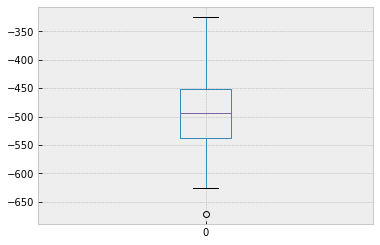

In [22]:
pd.DataFrame(n_scores).boxplot()

In [23]:
lassoCoefs0 = pd.DataFrame(
    data=reg.coef_[np.where(reg.coef_ != 0)[0]], 
    index=data[x_column_list].columns[np.where(reg.coef_ != 0)[0]],
columns=['LASSO Coefs1'])

In [24]:
lassoCoefs0

,LASSO Coefs1
Actinobacteriota,2506.281355
Firmicutes,3032.507448
Acidobacteriota,1043.380453
Chloroflexi,198.420414
Gemmatimonadota,-228.227864
Proteobacteria,2818.400617
Bacteroidota,571.313340
Verrucomicrobiota,-3200.212367
Patescibacteria,-8931.776826
Cyanobacteria,-4850.574585


In [25]:
feature_list4=lassoCoefs0

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted')

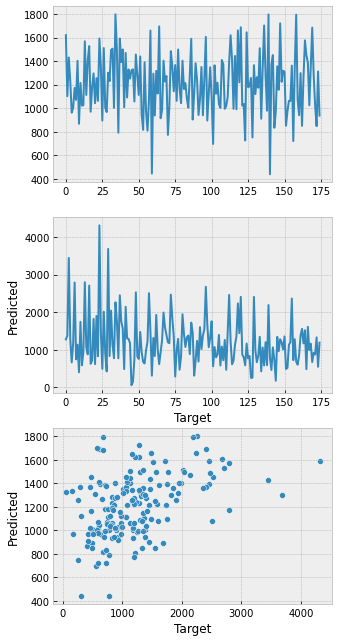

In [26]:
plt.figure(figsize=(5,11))

plt.subplot(3,1,1)
plt.plot(reg.predict(data_train[x_column_list]))

plt.subplot(3,1,2)
plt.plot(data_train[y_c].values)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.subplot(3,1,3)

sns.scatterplot(data_train[y_c].values,reg.predict(data_train[x_column_list]))
plt.xlabel('Target')
plt.ylabel('Predicted')

In [27]:
parameters = {'n_estimators':(10,20,100, 500),
                  'min_samples_split':(2,3,4),
                  'min_samples_leaf':(1,2,3)}

gb_model = GradientBoostingRegressor(random_state=7, warm_start=False)
grid_obj = GridSearchCV(gb_model, param_grid=parameters, verbose=1, n_jobs=4, cv=cv)
grid_obj = grid_obj.fit(data_train[x_column_list],data_train[y_c])
gb_model_best = grid_obj.best_estimator_
y_hat = gb_model_best.predict(data_val[x_column_list])

Fitting 30 folds for each of 36 candidates, totalling 1080 fits


/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted')

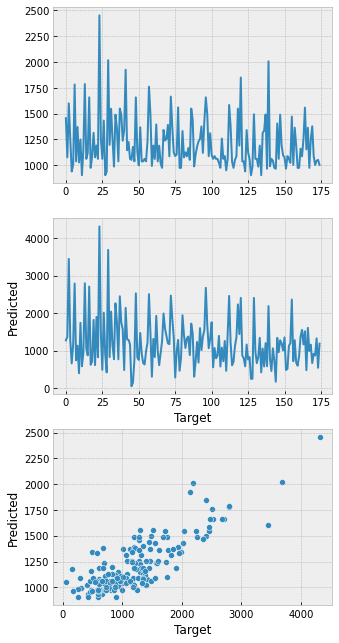

In [28]:
plt.figure(figsize=(5,11))

plt.subplot(3,1,1)
plt.plot(gb_model_best.predict(data_train[x_column_list]))

plt.subplot(3,1,2)
plt.plot(data_train[y_c].values)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.subplot(3,1,3)

sns.scatterplot(data_train[y_c].values,gb_model_best.predict(data_train[x_column_list]))
plt.xlabel('Target')
plt.ylabel('Predicted')

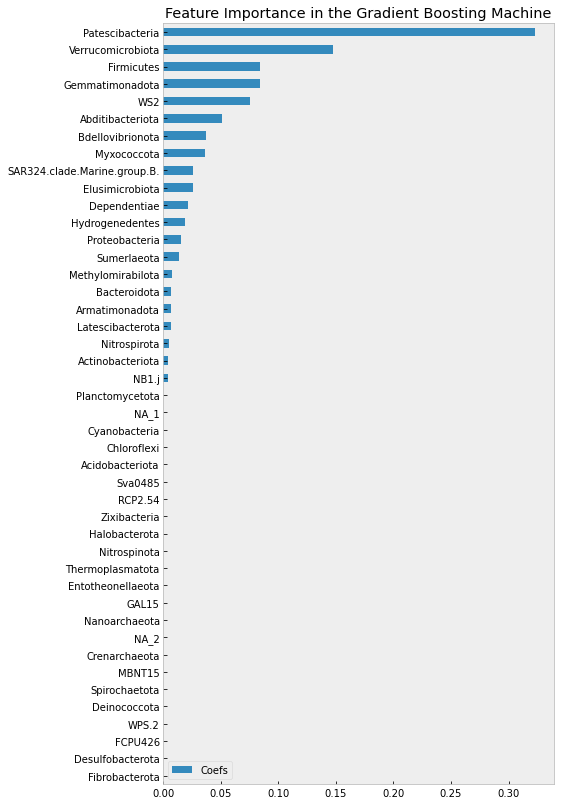

In [29]:
FeatImportance = gb_model_best.feature_importances_
GBCoefs = pd.DataFrame(index=data_train[x_column_list].columns, data=FeatImportance,columns=['Coefs'])
imp_coef = GBCoefs.sort_values(by='Coefs')
# plt.figure(figsize=(2,3),dpi=300)

imp_coef.plot(kind = "barh", figsize=(7,14))
plt.title("Feature Importance in the Gradient Boosting Machine")
plt.grid()

In [30]:
feature_list6=imp_coef.loc[imp_coef['Coefs']>np.quantile(imp_coef,0.7)]
feature_list6 = [item for item in feature_list6.index]

In [31]:
parameters = {'n_estimators':(10,20,100, 500),
              'min_samples_split':(2,3,4),
              'min_samples_leaf':(1,2,3)}

rf_model = RandomForestRegressor(warm_start=False)
grid_obj = GridSearchCV(rf_model, param_grid=parameters, verbose=1, n_jobs=4, cv=cv)
grid_obj = grid_obj.fit(data_train[x_column_list],data_train[y_c])
rf_model_best = grid_obj.best_estimator_
y_hat_rf = rf_model_best.predict(data_val[x_column_list])

Fitting 30 folds for each of 36 candidates, totalling 1080 fits


/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted')

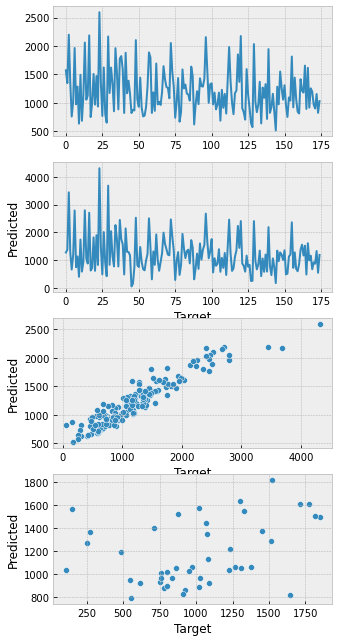

In [32]:
plt.figure(figsize=(5,11))

plt.subplot(4,1,1)
plt.plot(rf_model_best.predict(data_train[x_column_list]))

plt.subplot(4,1,2)
plt.plot(data_train[y_c].values)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.subplot(4,1,3)

sns.scatterplot(data_train[y_c].values,rf_model_best.predict(data_train[x_column_list]))
plt.xlabel('Target')
plt.ylabel('Predicted')

plt.subplot(4,1,4)
sns.scatterplot(data_val[y_c].values,rf_model_best.predict(data_val[x_column_list]))
plt.xlabel('Target')
plt.ylabel('Predicted')

In [33]:
rf_model_best.score(data_val[x_column_list],data_val[y_c])

-0.11675631002548581

In [34]:
rf_model_best.feature_importances_

array([0.02770948, 0.02836798, 0.07018906, 0.02541006, 0.02113295,
       0.03196283, 0.03273324, 0.01360748, 0.02692382, 0.02927279,
       0.05556281, 0.02716107, 0.11772955, 0.04428722, 0.03473964,
       0.03032407, 0.02498062, 0.03221612, 0.01622895, 0.02560826,
       0.03262816, 0.02856056, 0.01564702, 0.01721809, 0.07227088,
       0.0272614 , 0.01293523, 0.00728743, 0.00520671, 0.00263726,
       0.01193517, 0.0072663 , 0.01199483, 0.0017694 , 0.00146796,
       0.00068962, 0.00162569, 0.00889594, 0.01238771, 0.00071483,
       0.00067414, 0.00155632, 0.0009145 , 0.00030685])

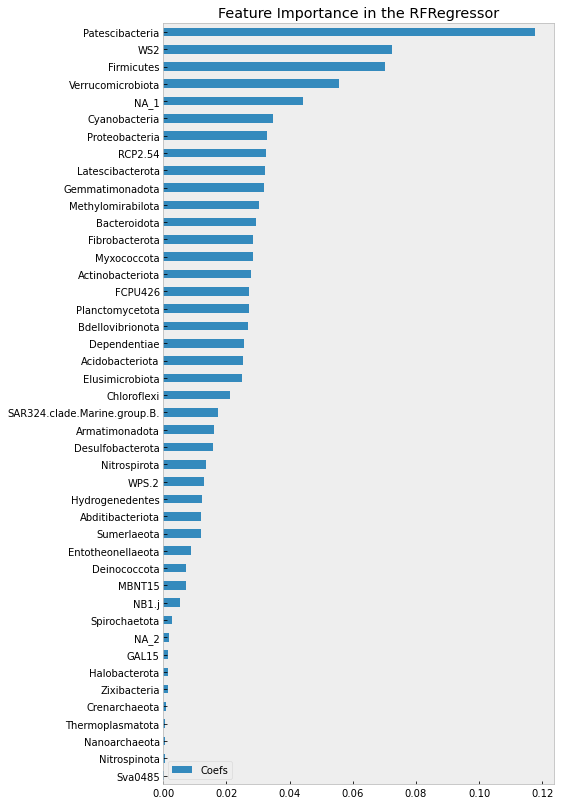

In [35]:
FeatImportance = rf_model_best.feature_importances_
RFCoefs = pd.DataFrame(index=data_train[x_column_list].columns, data=FeatImportance,columns=['Coefs'])
imp_coef_RF = RFCoefs.sort_values(by='Coefs')
# plt.figure(figsize=(2,3),dpi=300)

imp_coef_RF.plot(kind = "barh", figsize=(7,14))
plt.title("Feature Importance in the RFRegressor")
plt.grid()

In [36]:
feature_list7=imp_coef_RF.loc[imp_coef_RF['Coefs']>np.quantile(imp_coef_RF,0.7)]
feature_list7 = [item for item in feature_list7.index]

In [37]:
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 7.0)

def linearity_test(model, X,y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict(X)
    resids = fitted_vals - y

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=False, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=False, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

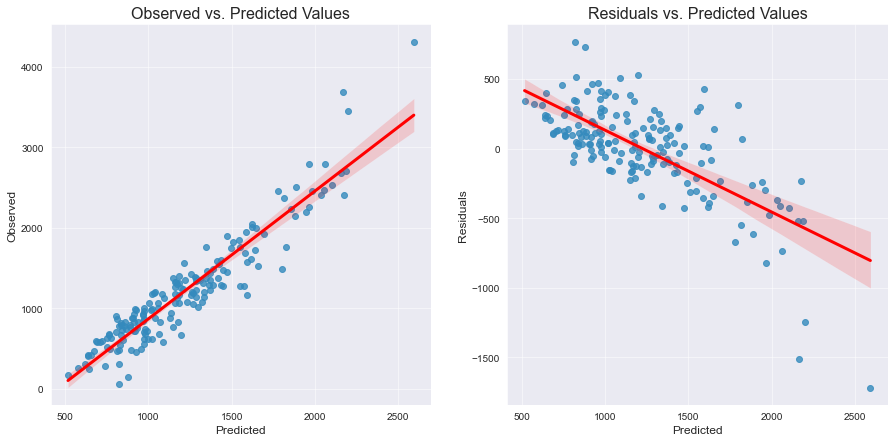

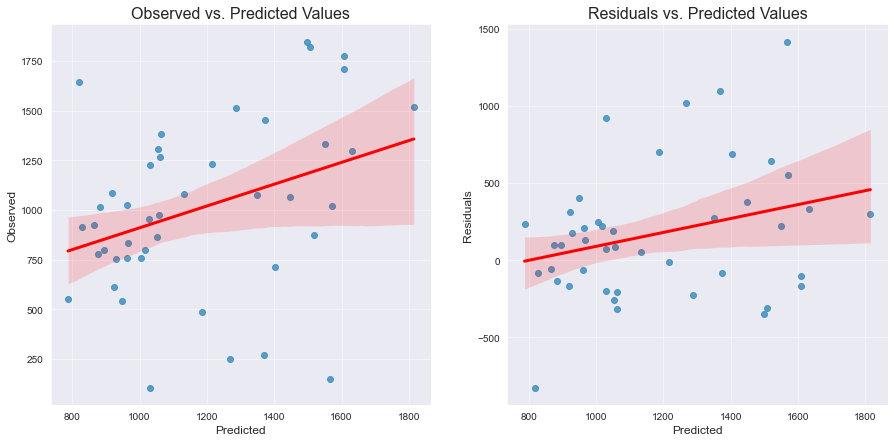

In [38]:
linearity_test(rf_model_best,data_train[x_column_list],data_train[y_c])
linearity_test(rf_model_best,data_val[x_column_list],data_val[y_c])

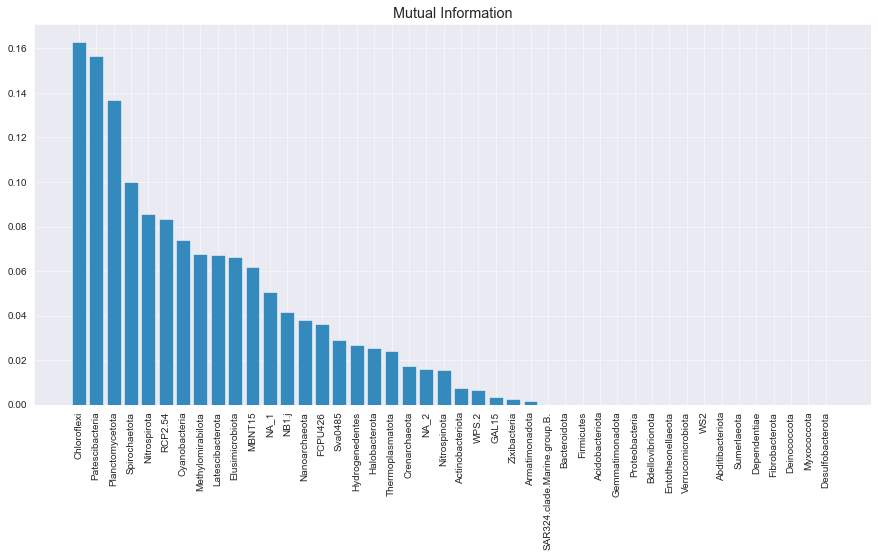

In [39]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(data_train[x_column_list],data_train[y_c], discrete_features=False, n_neighbors=3, copy=True, random_state=None)
MI=pd.DataFrame(mi)
MI['OTU']=data[x_column_list].columns
MI=MI.set_index('OTU')
MI=MI.sort_values(0,ascending=False)
plt.bar(MI.index,MI[0])
plt.xticks(rotation='vertical');
plt.title('Mutual Information')
feature_list8=MI[MI[0]>np.quantile(mi,0.7)].index

In [40]:
print('feature_list1', len(feature_list1), [item for item in feature_list1])
print('feature_list2', len(feature_list2), feature_list2['Variable'].values)
print('feature_list3', len(feature_list3), feature_list3)
print('feature_list4', len(feature_list4), [item for item in feature_list4.index])
#print('feature_list5', len(feature_list5), feature_list5)
print('feature_list6', len(feature_list6), feature_list6)
print('feature_list7', len(feature_list7), feature_list7)
print('feature_list8', len(feature_list8), [item for item in feature_list8])

feature_list1 12 ['Actinobacteriota', 'Chloroflexi', 'Proteobacteria', 'Firmicutes', 'Acidobacteriota', 'Gemmatimonadota', 'Bacteroidota', 'Nitrospirota', 'Verrucomicrobiota', 'Cyanobacteria', 'Myxococcota', 'Patescibacteria']
feature_list2 20 ['Chloroflexi' 'Patescibacteria' 'Methylomirabilota' 'MBNT15'
 'Spirochaetota' 'Cyanobacteria' 'Latescibacterota' 'Nanoarchaeota'
 'FCPU426' 'Hydrogenedentes' 'Proteobacteria' 'Elusimicrobiota'
 'Fibrobacterota' 'Halobacterota' 'Sva0485' 'Nitrospinota' 'WPS.2' 'NA_1'
 'Armatimonadota' 'Dependentiae']
feature_list3 6 ['Firmicutes', 'WS2', 'NB1.j', 'Latescibacterota', 'Verrucomicrobiota', 'Methylomirabilota']
feature_list4 11 ['Actinobacteriota', 'Firmicutes', 'Acidobacteriota', 'Chloroflexi', 'Gemmatimonadota', 'Proteobacteria', 'Bacteroidota', 'Verrucomicrobiota', 'Patescibacteria', 'Cyanobacteria', 'Methylomirabilota']
feature_list6 13 ['Proteobacteria', 'Hydrogenedentes', 'Dependentiae', 'Elusimicrobiota', 'SAR324.clade.Marine.group.B.', 'Myxoc

In [41]:
methodList = ['Maximum', 
              'KBest', 
              'Stepwise Regression', 
              'Lasso CV', 
              'GBM', 
              'Random Forest', 
              'Mutual Info']
featureList = [[item for item in feature_list1], 
               [item for item in feature_list2['Variable'].values], 
               feature_list3, 
               [item for item in feature_list4.index], 
               feature_list6, 
               feature_list7,
               [item for item in feature_list8]]

featureUniqueList = np.unique([item for sublist in featureList for item in sublist])
print(featureUniqueList)

['Abditibacteriota' 'Acidobacteriota' 'Actinobacteriota' 'Armatimonadota'
 'Bacteroidota' 'Bdellovibrionota' 'Chloroflexi' 'Cyanobacteria'
 'Dependentiae' 'Elusimicrobiota' 'FCPU426' 'Fibrobacterota' 'Firmicutes'
 'Gemmatimonadota' 'Halobacterota' 'Hydrogenedentes' 'Latescibacterota'
 'MBNT15' 'Methylomirabilota' 'Myxococcota' 'NA_1' 'NB1.j' 'Nanoarchaeota'
 'Nitrospinota' 'Nitrospirota' 'Patescibacteria' 'Planctomycetota'
 'Proteobacteria' 'RCP2.54' 'SAR324.clade.Marine.group.B.' 'Spirochaetota'
 'Sva0485' 'Verrucomicrobiota' 'WPS.2' 'WS2']


In [42]:
featureDictionary = dict.fromkeys(featureUniqueList)

In [43]:
for key in featureDictionary.keys():
    featureDictionary[key] = []
    

for feature in featureUniqueList:
    
    for i, method in enumerate(methodList):
        
        if feature in featureList[i]:
            featureDictionary[feature].append(method)   

In [44]:
featureDf = pd.DataFrame(index=featureUniqueList, columns=methodList)
featureDf['Count'] = 0

for feature in featureDictionary.keys():
    
    for method in methodList:
        
        if method in featureDictionary[feature]:
            
            featureDf['Count'][feature] += 1
            
            featureDf[method][feature] = 'X'
        else:
            featureDf[method][feature] = '-'           

/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/2923712238.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featureDf[method][feature] = '-'
/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/2923712238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featureDf['Count'][feature] += 1
/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/2923712238.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [45]:
featureDf.sort_values(by='Count', ascending=False, inplace=True)

In [46]:
featureDf

,Maximum,KBest,Stepwise Regression,Lasso CV,GBM,Random Forest,Mutual Info,Count
Patescibacteria,X,X,-,X,X,X,X,6
Firmicutes,X,-,X,X,X,X,-,5
Verrucomicrobiota,X,-,X,X,X,X,-,5
Cyanobacteria,X,X,-,X,-,X,X,5
Proteobacteria,X,X,-,X,X,X,-,5
Methylomirabilota,-,X,X,X,-,X,X,5
Latescibacterota,-,X,X,-,-,X,X,4
Gemmatimonadota,X,-,-,X,X,X,-,4
Chloroflexi,X,X,-,X,-,-,X,4
WS2,-,-,X,-,X,X,-,3


In [47]:
featureDf.to_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/ML/FeatureSelection.csv")

# Part three: Classification

In [48]:
pipe = Pipeline([('classifier', [RandomForestClassifier()])])
param_grid = [
    {'classifier' : [RandomForestClassifier()],
  #  'classifier__n_estimators' : list(range(10,100,10)),
    'classifier__max_features' : list(range(3,data.shape[1],2)),
    'classifier__criterion':('gini','entropy'),
    'classifier__class_weight':('balanced','auto')},   
]

In [49]:
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')

# Fit on data
clf_obj= clf.fit(data_train[x_column_list],data_train[y_b])
clf_model_best = clf_obj.best_estimator_

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1380 fits failed out of a total of 2760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1380 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sk

In [50]:
print(clf.best_params_)

print(clf.best_score_)

{'classifier': RandomForestClassifier(class_weight='balanced', max_features=15), 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_features': 15}
0.559644853896828


In [51]:
y_valid=clf_model_best.predict(data_val[x_column_list])
print(y_valid)
print(confusion_matrix(data_val[y_b], y_valid))
print(classification_report(data_val[y_b],y_valid))

[0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
[[ 9 13]
 [12 10]]
              precision    recall  f1-score   support

         0.0       0.43      0.41      0.42        22
         1.0       0.43      0.45      0.44        22

    accuracy                           0.43        44
   macro avg       0.43      0.43      0.43        44
weighted avg       0.43      0.43      0.43        44



In [52]:
matrix = confusion_matrix(data_val[y_b], y_valid)
Accuracy=matrix.diagonal()/matrix.sum(axis=1)
print('AccuracyClass0 ',Accuracy[0])
print('AccuracyClass1 ',Accuracy[1])

AccuracyClass0  0.4090909090909091
AccuracyClass1  0.45454545454545453


In [53]:
report_RF = classification_report(data_val[y_b],y_valid,output_dict=True)
weightedF1_RF = report_RF['weighted avg']['f1-score']
F1_0_class_RF=report_RF['0.0']['f1-score']
F1_1_class_RF=report_RF['1.0']['f1-score']
print(weightedF1_RF,F1_0_class_RF,F1_1_class_RF)

0.43152454780361765 0.4186046511627907 0.4444444444444445


In [54]:
dRF = pd.DataFrame(report_RF).transpose()

# ALL Model

In [55]:
pipe = Pipeline([('classifier', [RandomForestClassifier(),DecisionTreeClassifier(),SGDClassifier(),SVC(),KNeighborsClassifier()])])
param_grid = [
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,100,10)),
#     'classifier__max_features' : list(range(3,data.shape[1],3)),
#     'classifier__criterion':('gini','entropy'),
#     'classifier__class_weight':('balanced','auto')},   
#     {'classifier' : [DecisionTreeClassifier()],
#     'classifier__criterion':  ['gini', 'entropy'],
#     'classifier__max_depth':  [None, 2, 4, 6, 8, 10],
#     'classifier__max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
#     'classifier__splitter': ['best', 'random']}, 
    {'classifier' : [SGDClassifier()],
    'classifier__alpha': [10 ** a for a in range(-6, -1)],
    'classifier__loss': ['hinge','modified_huber','squared_hinge','perceptron','huber','epsilon_insensitive'], 
    'classifier__penalty': ['l2','l1','elasticnet']},
     {'classifier' : [SVC()],      
    'classifier__C': [0.1,1, 10, 100],
    'classifier__class_weight':('balanced','auto'),
    'classifier__gamma' : [1,0.1,0.01,0.001]},
    #'classifier__ kernel': ['rbf', 'poly', 'sigmoid']},
#     {'classifier' : [KNeighborsClassifier()],
#      'classifier__n_neighbors':list(range(1,15))}     
]

In [56]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [57]:

clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')

# Fit on data
clf.fit(data_train[x_column_list],data_train[y_b])
clf_model_best = clf.best_estimator_




/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 3660.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/skle

In [58]:
print(clf.best_params_)

print(clf.best_score_)


{'classifier': SGDClassifier(alpha=0.001, loss='squared_hinge', penalty='elasticnet'), 'classifier__alpha': 0.001, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'elasticnet'}
0.6013630176755205


[[13  9]
 [11 11]]
              precision    recall  f1-score   support

         0.0       0.54      0.59      0.57        22
         1.0       0.55      0.50      0.52        22

    accuracy                           0.55        44
   macro avg       0.55      0.55      0.54        44
weighted avg       0.55      0.55      0.54        44



/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/723094834.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


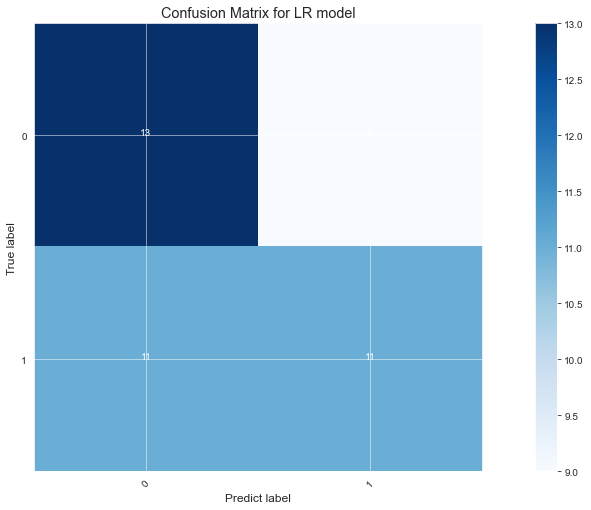

AccuracyClass0  0.5909090909090909
AccuracyClass1  0.5


In [59]:
y_valid=clf_model_best.predict(data_val[x_column_list])
print 

print(confusion_matrix(data_val[y_b], y_valid))
print(classification_report(data_val[y_b],y_valid))
plot_confusion_matrix(confusion_matrix(data_val[y_b], y_valid), classes=range(2),
                      normalize=False, title='Confusion Matrix for LR model')
matrix = confusion_matrix(data_val[y_b], y_valid)
Accuracy=matrix.diagonal()/matrix.sum(axis=1)
print('AccuracyClass0 ',Accuracy[0])
print('AccuracyClass1 ',Accuracy[1])

In [60]:
report_All = classification_report(data_val[y_b],y_valid,output_dict=True)
weightedF1_All = report_All['weighted avg']['f1-score']
F1_0_class_All=report_All['0.0']['f1-score']
F1_1_class_All=report_All['1.0']['f1-score']
print(weightedF1_All,F1_0_class_All,F1_1_class_All)

0.5445134575569358 0.5652173913043478 0.5238095238095238


In [61]:
dAll=pd.DataFrame(report_All).transpose()

# Classification by selected feature 

In [62]:
pipe = Pipeline([('classifier', [RandomForestClassifier()])])
param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,100,10)),
    'classifier__max_features' : list(range(3,data.shape[1],3)),
    'classifier__criterion':('gini','entropy'),
    'classifier__class_weight':('balanced','auto')},   
]

In [63]:
featureDf['Count'].max()

6

In [64]:
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')
f_k=[]
for k in range(0,2):
    selected_features=featureDf[featureDf['Count']>k].index 
    clf.fit(data_train[selected_features],data_train[y_b])
    best_clf=clf.best_estimator_
    y_valid = best_clf.predict(data_val[selected_features])
    report_selected = classification_report(data_val[y_b],y_valid,output_dict=True)
    weightedF1_selected = report_selected['weighted avg']['f1-score']
    F1_0_selected=report_selected['0.0']['f1-score']
    F1_1_selected=report_selected['1.0']['f1-score']
    selected_k=[k,weightedF1_selected,F1_0_selected,F1_1_selected]
    f_k.append(weightedF1_selected) 
    print(selected_k)
number_feature=np.where(f_k==np.array(f_k).max())[0][0] 

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8100 fits failed out of a total of 16200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/s

[0, 0.44999999999999996, 0.39999999999999997, 0.4999999999999999]
[1, 0.5900621118012421, 0.5714285714285713, 0.6086956521739131]


/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8100 fits failed out of a total of 16200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/s

In [65]:
selected_features=featureDf[featureDf['Count']>number_feature].index

In [66]:
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')
clf.fit(data_train[selected_features],data_train[y_b])
best_clf=clf.best_estimator_

y_valid = best_clf.predict(data_val[selected_features])


/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8100 fits failed out of a total of 16200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/s

[[12 10]
 [11 11]]
              precision    recall  f1-score   support

         0.0       0.52      0.55      0.53        22
         1.0       0.52      0.50      0.51        22

    accuracy                           0.52        44
   macro avg       0.52      0.52      0.52        44
weighted avg       0.52      0.52      0.52        44



/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/723094834.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


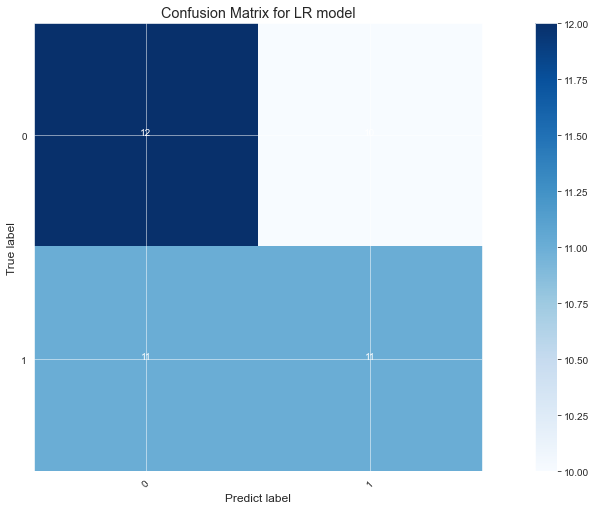

AccuracyClass0  0.5454545454545454
AccuracyClass1  0.5


In [67]:
print(confusion_matrix(data_val[y_b], y_valid))
print(classification_report(data_val[y_b],y_valid))
plot_confusion_matrix(confusion_matrix(data_val[y_b], y_valid), classes=range(2),
                      normalize=False, title='Confusion Matrix for LR model')
matrix = confusion_matrix(data_val[y_b], y_valid)
Accuracy=matrix.diagonal()/matrix.sum(axis=1)
print('AccuracyClass0 ',Accuracy[0])
print('AccuracyClass1 ',Accuracy[1])

In [68]:
report_selected = classification_report(data_val[y_b],y_valid,output_dict=True)
weightedF1_selected = report_selected['weighted avg']['f1-score']
F1_0_selected=report_selected['0.0']['f1-score']
F1_1_selected=report_selected['1.0']['f1-score']
print(weightedF1_selected,F1_0_selected,F1_1_selected)

0.5224806201550387 0.5333333333333332 0.5116279069767442


In [69]:
dfselected1=pd.DataFrame(report_selected).transpose()

# from original data and selected features

In [70]:
new_column_list = [col.replace('.','-') for col in selected_features]

In [71]:
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, n_jobs=-1, scoring='f1_weighted')
selected_features
# Fit on data
clf.fit(data_original[new_column_list].div(data_original[new_column_list].sum(axis=1), axis=0)[0:len(data_train[y_b])],data_train[y_b])
clf_best_model=clf.best_estimator_

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8100 fits failed out of a total of 16200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/s

In [72]:
print(clf.best_params_)

print(clf.best_score_)
y_valid=clf_best_model.predict(data_original[new_column_list].div(data_original[new_column_list].sum(axis=1), axis=0)[len(data_train[y_b]):])
print(y_valid)

{'classifier': RandomForestClassifier(class_weight='balanced', max_features=45,
                       n_estimators=30), 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_features': 45, 'classifier__n_estimators': 30}
0.5270552609913
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.]


[[14  8]
 [14  8]]
              precision    recall  f1-score   support

         0.0       0.50      0.64      0.56        22
         1.0       0.50      0.36      0.42        22

    accuracy                           0.50        44
   macro avg       0.50      0.50      0.49        44
weighted avg       0.50      0.50      0.49        44



/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/723094834.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


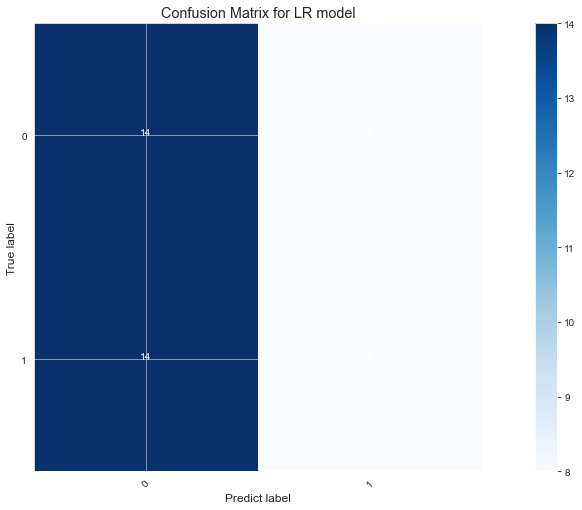

AccuracyClass0  0.6363636363636364
AccuracyClass1  0.36363636363636365


In [73]:
print(confusion_matrix(data_val[y_b], y_valid))
print(classification_report(data_val[y_b],y_valid))
plot_confusion_matrix(confusion_matrix(data_val[y_b], y_valid), classes=range(2),
                      normalize=False, title='Confusion Matrix for LR model')
matrix = confusion_matrix(data_val[y_b], y_valid)
Accuracy=matrix.diagonal()/matrix.sum(axis=1)
print('AccuracyClass0 ',Accuracy[0])
print('AccuracyClass1 ',Accuracy[1])

In [74]:
report_selected2 = classification_report(data_val[y_b],y_valid,output_dict=True)
weightedF1_selected2 = report_selected2['weighted avg']['f1-score']
F1_0_selected2=report_selected2['0.0']['f1-score']
F1_1_selected2=report_selected2['1.0']['f1-score']
print(weightedF1_selected2,F1_0_selected2,F1_1_selected2)

0.4905263157894737 0.56 0.4210526315789474


In [75]:
dfselected2=pd.DataFrame(report_selected2).transpose()

In [76]:
dfselected=pd.merge(dfselected1,dfselected2,on=dfselected2.index)


# Clustering

In [77]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from kneed import KneeLocator

In [78]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[x_column_list])
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [79]:
# The lowest SSE value
print('The lowest SSE value',kmeans.inertia_)

# Final locations of the centroid
print('Final locations of the centroid',kmeans.cluster_centers_)
# The number of iterations required to converge
print('The number of iterations required to converge',kmeans.n_iter_)

The lowest SSE value 1.7801423679441892
Final locations of the centroid [[ 2.18920287e-01  3.29649886e-02  8.69673187e-02  1.25361238e-01
   1.04724441e-01  4.45698398e-02  2.38293361e-01  1.16647385e-02
   4.53703973e-03  5.26649356e-02  3.98946784e-02  4.64403155e-03
   1.21108435e-02  1.31326965e-03  6.10499733e-03  4.08902772e-03
   1.15671806e-03  1.90333511e-03  1.28863512e-03  7.03107277e-04
   8.93560991e-04  1.33724236e-03  9.83924178e-04  2.08417297e-04
   2.32548823e-04  8.15155332e-04  5.49477173e-04  2.85996264e-04
   2.06331616e-04  1.03637646e-04  9.35030985e-05  8.68357841e-05
   3.19656315e-05  1.17751612e-05  3.96458127e-05  7.38129607e-06
   1.29021046e-05  5.94657152e-05  1.69909149e-05  1.37988747e-04
   3.66691078e-06  1.54337212e-06  3.21231406e-06 -1.21972744e-19]
 [ 1.93557279e-01  3.13187930e-02  3.57935993e-02  1.30344918e-01
   1.61514232e-01  4.09866210e-02  2.25798583e-01  9.82917471e-03
   3.51897348e-03  5.97811996e-02  3.86093524e-02  8.17494852e-03
   

[[44 67]
 [52 56]]
              precision    recall  f1-score   support

         0.0       0.46      0.40      0.43       111
         1.0       0.46      0.52      0.48       108

    accuracy                           0.46       219
   macro avg       0.46      0.46      0.45       219
weighted avg       0.46      0.46      0.45       219



/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_39822/723094834.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


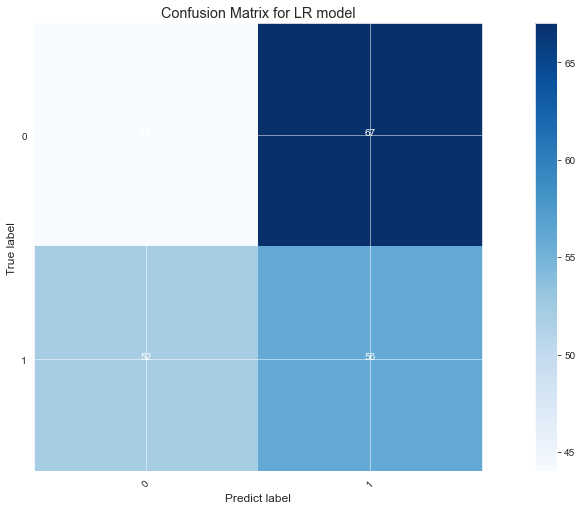

AccuracyClass0  0.3963963963963964
AccuracyClass1  0.5185185185185185


In [80]:
print(confusion_matrix(data[y_b],  kmeans.labels_))
print(classification_report(data[y_b],kmeans.labels_))
plot_confusion_matrix(confusion_matrix(data[y_b],kmeans.labels_), classes=range(2),
                      normalize=False, title='Confusion Matrix for LR model')
matrix = confusion_matrix(data[y_b],kmeans.labels_)
Accuracy=matrix.diagonal()/matrix.sum(axis=1)
print('AccuracyClass0 ',Accuracy[0])
print('AccuracyClass1 ',Accuracy[1])

In [81]:
kmeans.labels_.sum()

123

In [82]:
print('1:',kmeans.labels_.sum(),'0:',data.shape[0]-kmeans.labels_.sum())

1: 123 0: 96


In [83]:
data_kmeans=data.copy()
data_kmeans['kmeans']=kmeans.labels_

<AxesSubplot:xlabel='kmeans', ylabel='Yield_per_plant'>

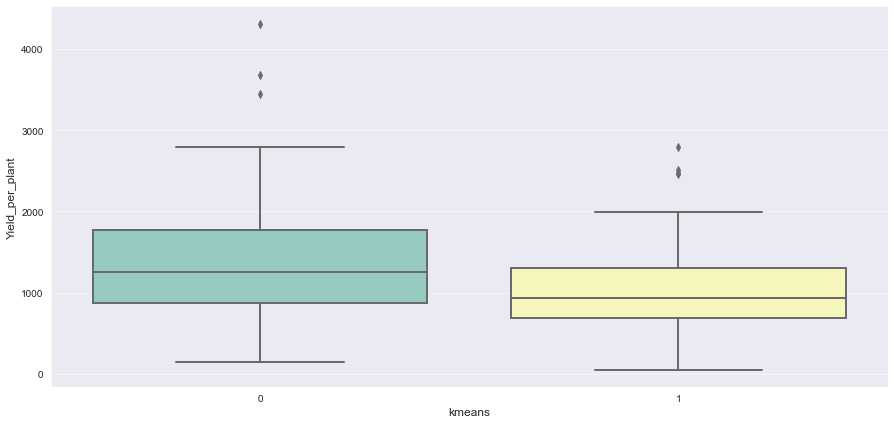

In [84]:
sns.boxplot(data=data_kmeans,y=data_kmeans[y_c],x="kmeans",palette="Set3")

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 4500.0)

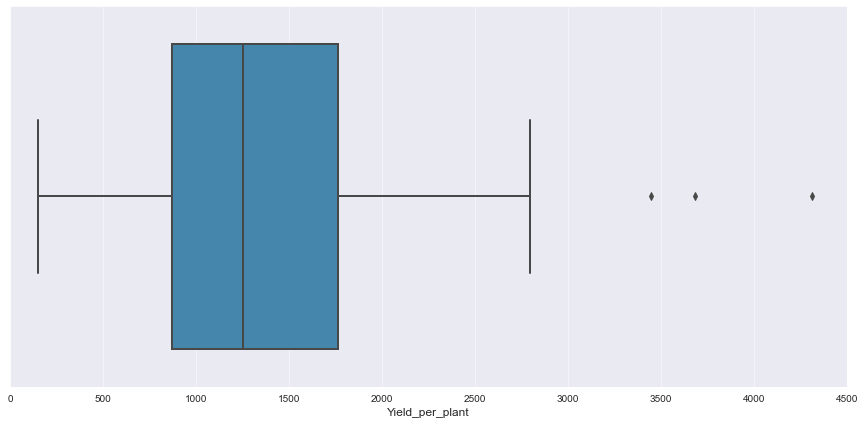

In [85]:
sns.boxplot(data_kmeans[data_kmeans['kmeans']==0][y_c])
plt.xlim([0,4500])

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 4500.0)

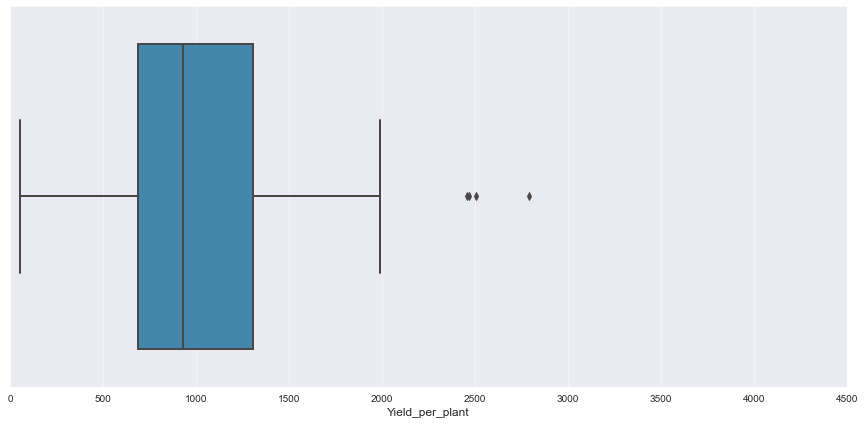

In [86]:
sns.boxplot(data_kmeans[data_kmeans['kmeans']==1][y_c])
plt.xlim([0,4500])

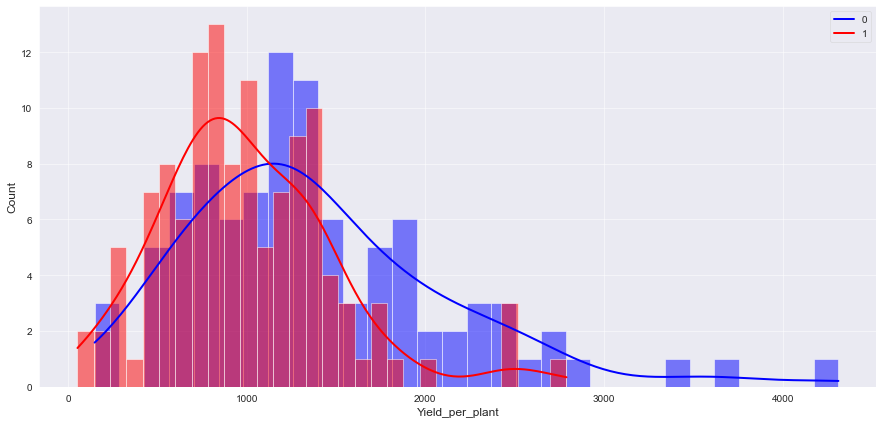

In [87]:
sns.histplot(data_kmeans[data_kmeans['kmeans']==0][y_c],bins=30,kde=True)
sns.histplot(data_kmeans[data_kmeans['kmeans']==1][y_c],bins=30,color='red',kde=True)
plt.legend([0,1])

Text(0, 0.5, 'Sample Label')

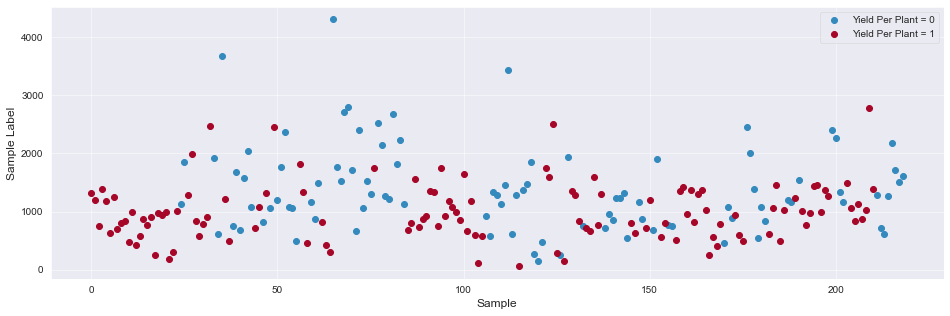

In [88]:
plt.figure(figsize=(16,5))
plt.plot(data_kmeans[y_c].loc[data_kmeans['kmeans']==0],'o')
plt.plot(data_kmeans[y_c].loc[data_kmeans['kmeans']==1],'o')
plt.legend(['Yield Per Plant = 0', 'Yield Per Plant = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')

In [89]:
report_k_means= classification_report(data[y_b],kmeans.labels_,output_dict=True)
weightedF1_k_means = report_k_means['weighted avg']['f1-score']
F1_0_class_k_means=report_k_means['0.0']['f1-score']
F1_1_class_k_means=report_k_means['1.0']['f1-score']
print(weightedF1_k_means,F1_0_class_k_means,F1_1_class_k_means)

dK_means=pd.DataFrame(report_k_means).transpose()

0.45457553498053793 0.4251207729468599 0.48484848484848486


In [90]:
dfselected=pd.merge(dfselected1,dfselected2,on=dfselected2.index)
dK_means['key_0']=dK_means.index
c_1=pd.merge(dRF,dAll,on=dRF.index)
c_2=pd.merge(c_1,dK_means,on='key_0')
c_3=pd.merge(c_2,dfselected,on='key_0')
coln=['class','precision_RF','recall_RF','f1_RF','support_RF','precision_All','recall_All','f1_All','support_All','precision_k-m','recall_k-m','f1-score_k-m','support_k-m','precision_selected1','recall_selected1','f1-score_selected1','support_selected1','precision_selected2','recall_selected2','f1-score_selected2','support_selected2']
c_3.columns=coln
f1_cols = [col for col in c_3.columns if 'f1' in col]
c_f1_t=c_3[f1_cols]
c_f1=pd.DataFrame(c_f1_t.iloc[4,:])
c_f1.rename(columns={4:'f1'}, inplace=True)
namemethod=c_f1['f1'].idxmax()
f_0=c_f1_t[namemethod][0]
f_1=c_f1_t[namemethod][1]
BestF=[namemethod,f_0,f_1]
F1_0_class_RF=c_3.iloc[0,3]
F1_1_class_RF=c_3.iloc[1,3]

In [91]:
c_3.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/ML/reportclasssification.csv')

In [92]:
F1_0_class_RF=c_3['f1_RF'][0]
F1_1_class_RF=c_3['f1_RF'][1]

In [93]:
BestF=[namemethod,f_0,f_1]

In [94]:
BestF

['f1_All', 0.5652173913043478, 0.5238095238095238]

In [95]:
[F1_0_class_RF,F1_1_class_RF]

[0.4186046511627907, 0.4444444444444445]

# Comparing to random

In [96]:
NumofR=100
out_random=Compare_random(data,NumofR)

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/sklearn

In [97]:
print(out_random[4])

[0.54, 0.31, 0.54, 0.56]


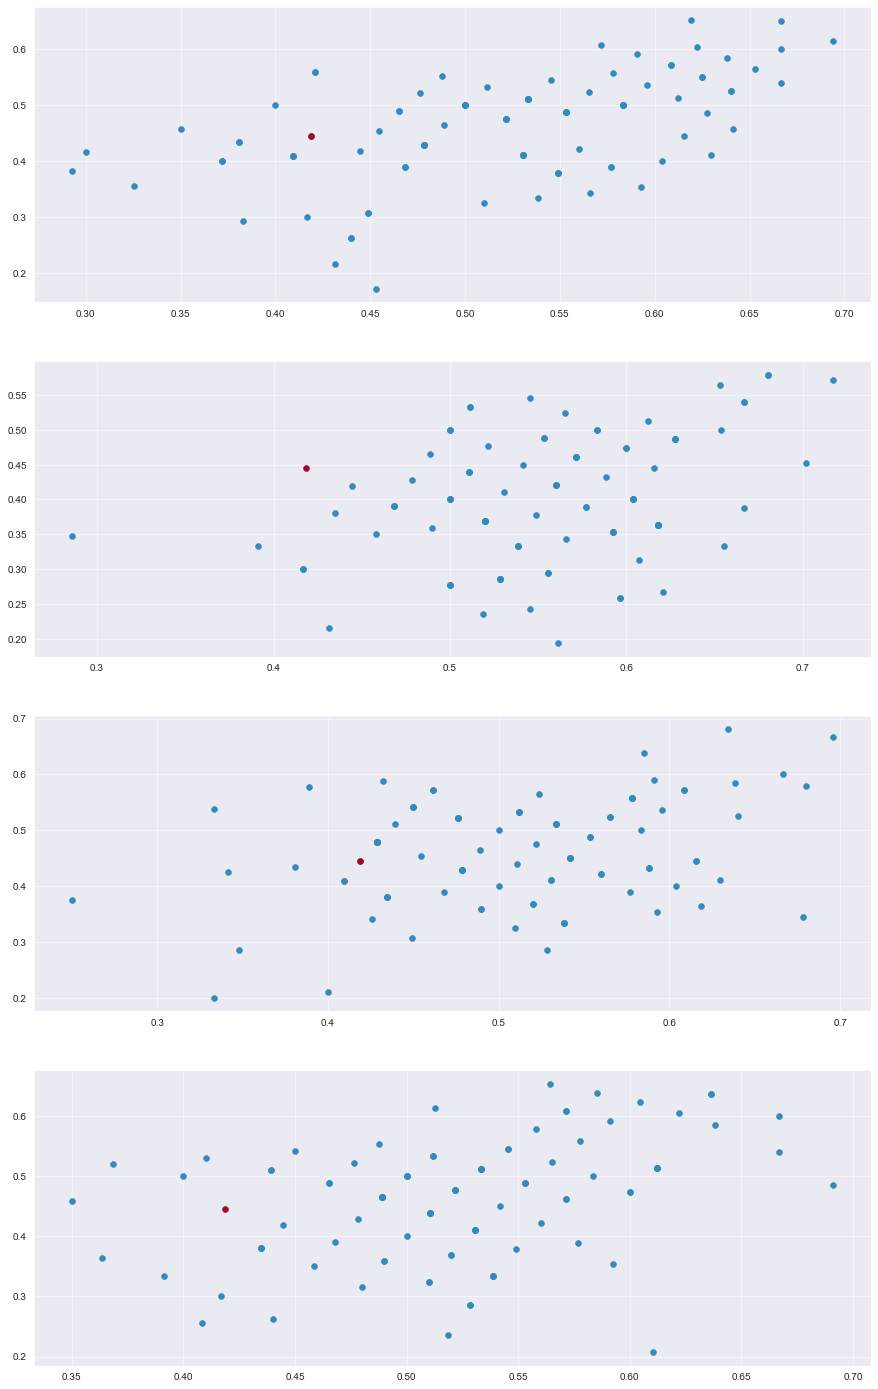

In [98]:
plt.figure(figsize=(15,25))
plt.subplot(4,1,1)
r1=out_random[0]
plt.scatter(r1['0'],r1['1'])
plt.scatter(F1_0_class_RF,F1_1_class_RF)
plt.subplot(4,1,2)
r2=out_random[1]
plt.scatter(r2['0'],r2['1'])
plt.scatter(F1_0_class_RF,F1_1_class_RF)
plt.subplot(4,1,3)
r3=out_random[2]
plt.scatter(r3['0'],r3['1'])
plt.scatter(F1_0_class_RF,F1_1_class_RF)
plt.subplot(4,1,4)
r4=out_random[3]
plt.scatter(r4['0'],r4['1'])
plt.scatter(F1_0_class_RF,F1_1_class_RF)
plt.savefig('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/ML/compareTorandom1-1.png',facecolor='white')